# Thumos task

In order to better focus outreach efforts in the future, we need to determine which characteristics show a higher probability of purchasing a membership and/or purchasing an event ticket.

The column Result has one of six outcomes for each person:
+ Purchased membership: The ideal outcome, bought an event ticket and a membership
+ Purchased event: A positive outcome but not ideal
+ Approved: They were approved to come to an event but did not purchase
+ Sent personal f/u: Conversation was started but ended
+ Out of sequence: Conversation was started but ended
+ 2021 Member: Someone who was a previous member of the organization

## Preparing for work

Importing libraries

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from geopy.geocoders import Nominatim
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

Loading data

In [2]:
data = pd.read_excel('Linkedin Accounts That Purchased Memberships.xlsx')

Checking information about columns

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 74 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   linkedinProfile               348 non-null    object        
 1   Result                        348 non-null    object        
 2   Other                         191 non-null    object        
 3   email                         216 non-null    object        
 4   description                   278 non-null    object        
 5   headline                      347 non-null    object        
 6   location                      348 non-null    object        
 7   firstName                     348 non-null    object        
 8   lastName                      348 non-null    object        
 9   fullName                      348 non-null    object        
 10  subscribers                   347 non-null    float64       
 11  userId                        28

## Location analysis

Getting coordinates for displaying data on a graph

In [4]:
geolocator = Nominatim(user_agent="geoparser")

def get_coor(location):
    try:
        coor = geolocator.geocode(location)
        return coor.latitude, coor.longitude
    except:
        return np.nan, np.nan

tqdm.pandas(desc="Getting coordinates for locations: ")
coordinates = data.location.progress_apply(get_coor)

data_coor = pd.DataFrame([coordinates.apply(lambda x: x[0]), coordinates.apply(lambda x: x[1])]).transpose()
data_coor.columns = ['latitude', 'longitude']
data_coor['location'] = data['location']
data_coor['result'] = data['Result']
data_coor['result_nums'] = data_coor['result'].apply(lambda x: np.argwhere(data_coor['result'].unique() == x)[0][0])

Getting coordinates for locations:   0%|          | 0/348 [00:00<?, ?it/s]

Data distribution scatter plots

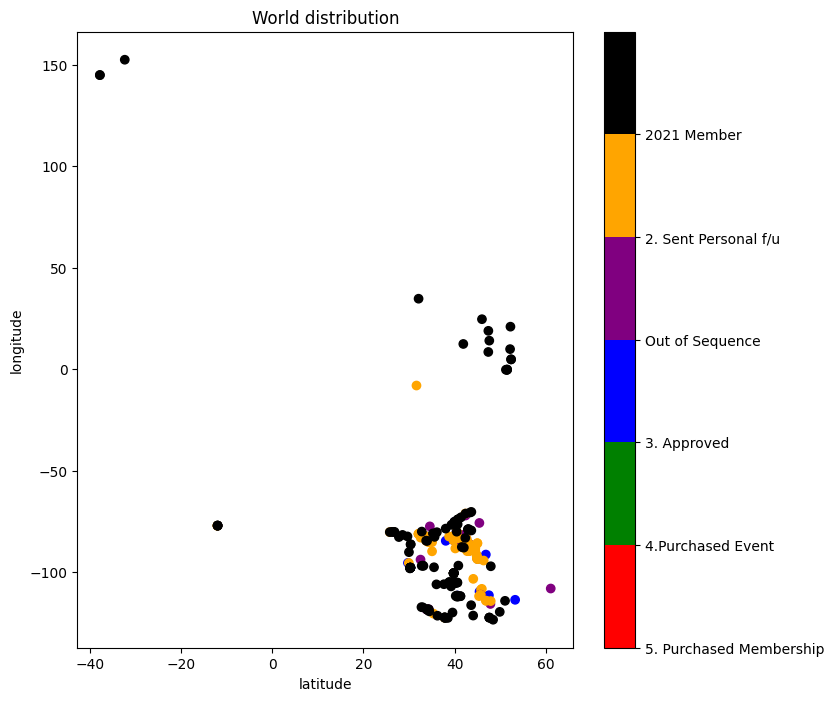

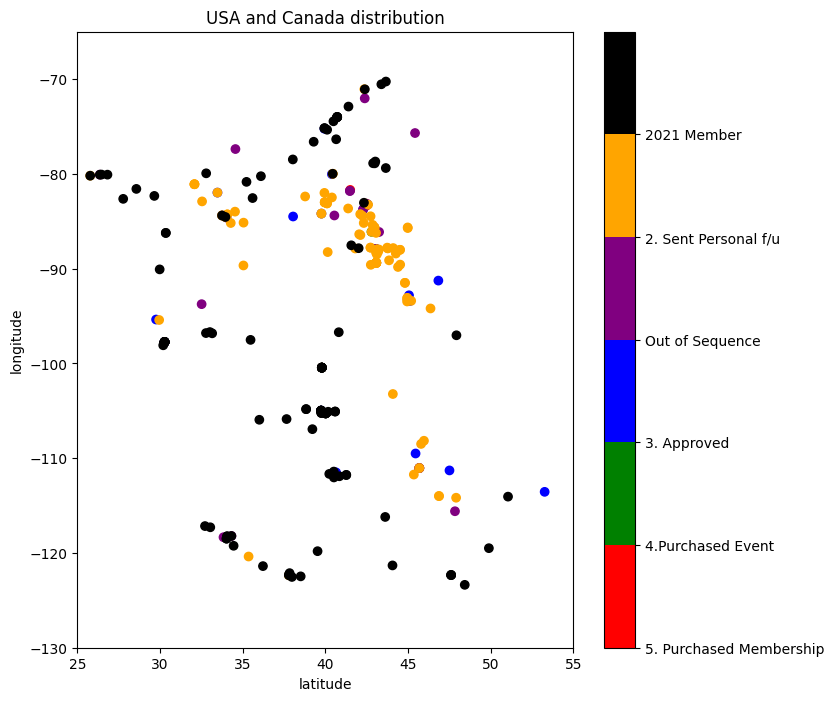

In [5]:
colors = ['red','green','blue','purple','orange','black']
def geo_graph(title, xlim=None, ylim=None):
    fig = plt.figure(figsize=(8,8))
    plt.scatter(
        data_coor['latitude'],
        data_coor['longitude'],
        c=data_coor['result_nums'],
        cmap=matplotlib.colors.ListedColormap(colors),
    )
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    plt.title(title)
    plt.xlabel('latitude')
    plt.ylabel('longitude')
    cb = plt.colorbar()
    loc = np.arange(0,max(data_coor['result_nums']),max(data_coor['result_nums'])/float(len(colors)))
    cb.set_ticks(loc)
    cb.set_ticklabels(list(data_coor['result'].unique()))

geo_graph('World distribution')
geo_graph('USA and Canada distribution' , (25,55), (-130,-65))

On USA distribution graph we can a cluster of clients, which was started conversation but ended.

## Preparing data

Creating binary target for classification:

+ Customers of interest
+ Uninteresting customers

In [6]:
data_coor = data_coor.dropna().reset_index(drop=True)

data_coor['binary_result'] = data_coor['result'].replace({
    '5. Purchased Membership': 1,
    '4.Purchased Event': 1,
    '2021 Member': 1,
    '2. Sent Personal f/u': 0,
    '3. Approved': 0,
    'Out of Sequence': 0
})

data_coor['binary_result'].value_counts()

binary_result
0    155
1    149
Name: count, dtype: int64

Splitting data

In [7]:
RANDOM_STATE = 42
data_train, data_test = train_test_split(data_coor, test_size=0.6, stratify=data_coor['result'], random_state=RANDOM_STATE)

Getting features and target

In [8]:
features_train = data_train.drop(columns=['location', 'result', 'result_nums', 'binary_result'])
features_test = data_test.drop(columns=['location', 'result', 'result_nums', 'binary_result'])
target_train = data_train['binary_result']
target_test = data_test['binary_result']

Searching best ML model using grid search with cross-validation

In [9]:
models = {
    'LogisticRegression':{
        'estimator':LogisticRegression(),
        'params':{
            'C':np.arange(0.5, 5, 0.5),
            'solver':['liblinear'],
            'random_state':[RANDOM_STATE]
        }
    },
    'DecisionTreeClassifier':{
        'estimator':DecisionTreeClassifier(),
        'params':{
            'max_depth':range(1, 5),
            'random_state':[RANDOM_STATE]
        }
    },
    'RandomForestClassifier':{
        'estimator':RandomForestClassifier(),
        'params':{
            'max_depth':range(1, 5),
            'n_estimators':range(100, 501, 100),
            'random_state':[RANDOM_STATE]
        }
    }
}

models_table = []

for model in tqdm(models):
    clf = GridSearchCV(
        estimator=models[model]['estimator'],
        param_grid=models[model]['params'],
        scoring='roc_auc',
        n_jobs=-1,
        cv=4
    )
    clf.fit(features_train, target_train)
    models_table.append([models[model]['estimator'], clf.best_params_, clf.best_score_, clf.best_estimator_])

models_table.sort(key=lambda x: x[2], reverse=True)
best_model = models_table[0][3]
best_model_name = models_table[0][0]

models_table_df = pd.DataFrame(models_table)
models_table_df.columns = ['Model', 'Params', 'Score', 'Estimator']
pd.set_option('display.max_colwidth', None)
print("Table of models")
models_table_df.drop(columns=['Estimator'])

  0%|          | 0/3 [00:00<?, ?it/s]

Table of models


,Model,Params,Score
0,RandomForestClassifier(),"{'max_depth': 3, 'n_estimators': 400, 'random_state': 42}",0.871620
1,DecisionTreeClassifier(),"{'max_depth': 2, 'random_state': 42}",0.858088
2,LogisticRegression(),"{'C': 3.5, 'random_state': 42, 'solver': 'liblinear'}",0.594623


Testing the best model on test data

In [10]:
proba = best_model.predict_proba(features_test)[:, 1]
predicted = best_model.predict(features_test)
roc_auc_score(target_test, proba)
print(accuracy_score(target_test, predicted))
print(roc_auc_score(target_test, proba))

0.8032786885245902
0.849283154121864


## Conclusion

Based on location of a potential client, the model predicts whether this client will become a member or purchase event with an accuracy of 80.3%.